# Linear Regression with the Boston Housing Dataset
**Date:** January 25, 2025  
**Author:** Dario Piga  

In this notebook, we will implement a multivariate linear regression model using PyTorch to predict housing prices in Boston. We will use multiple features from the dataset to build our model, allowing us to examine how various factors, such as the number of rooms, crime rate, pupil-teacher ratio, and the economic status of the population, influence home prices.

## The Boston Housing Dataset

The "Boston Housing" dataset contains information collected by the U.S Census Service concerning the Boston, Massachusetts area. This dataset is widely used as a benchmark for regression algorithms and includes the following features:

- `CRIM`: Per capita crime rate by town
- `ZN`: Proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`: Proportion of non-retail business acres per town
- `CHAS`: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- `NOX`: Nitric oxides concentration (parts per 10 million)
- `RM`: Average number of rooms per dwelling
- `AGE`: Proportion of owner-occupied units built prior to 1940
- `DIS`: Weighted distances to five Boston employment centers
- `RAD`: Index of accessibility to radial highways
- `TAX`: Full-value property-tax rate per 10,000
- `PTRATIO`: Pupil-teacher ratio by town
- `B`: 1000(Bk - 0.63)$^2$ where Bk is the proportion of blacks by town. This variable has been criticized as unethical in its formulation.
- `LSTAT`: % lower status of the population
- `MEDV`: Median value of owner-occupied homes in 1000's

## Selected Variables for Analysis

In this exercise, we will use a subset of features from the Boston Housing Dataset to develop our regression model. Below is a detailed description of each feature that will be included in our analysis:

- `CRIM`: This feature represents the per capita crime rate by town. Higher crime rates can negatively impact housing prices due to perceived safety concerns.

- `RM`: The average number of rooms per dwelling. Generally, a higher number of rooms indicates more space, which can positively influence the housing price.

- `PTRATIO`: Pupil-teacher ratio by town. A lower pupil-teacher ratio is often associated with better educational resources, making the area more attractive to families with children.

- `LSTAT`: Percentage of lower status of the population. Higher percentages can indicate socioeconomic challenges, which may lower property values.

These variables have been chosen because they provide insights into different aspects of residential areas that can directly affect housing prices, such as safety, space, education, and socioeconomic status.


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# load data and prepare the dataset

# URL for the Boston Housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"

# Attempt to read the dataset via Pandas
try:
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

    # Assuming the data rows are structured as alternating feature and target rows.
    # Data structure needs to interleave these rows correctly.
    data = np.vstack([np.hstack([raw_df.values[2*i, :], raw_df.values[2*i+1, :2]]) for i in range(raw_df.shape[0] // 2)])
    target = raw_df.values[1::2, 2]

    # Creating a DataFrame from the processed data
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    # Ensure the number of columns in 'data' matches the length of 'feature_names'
    df = pd.DataFrame(data, columns=feature_names)
    df['MEDV'] = target  # Adding the target variable

    print("Processed DataFrame:")
    print(df.head())

except Exception as e:
    print("Error loading or processing the dataset:", e)


print(f"Datset shape: {df.shape}")

Processed DataFrame:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
Datset shape: (506, 14)


In [3]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [ ]:
# Selecting specific features and plots (TO BE DONE)
...

Text(0, 0.5, 'Frequency')

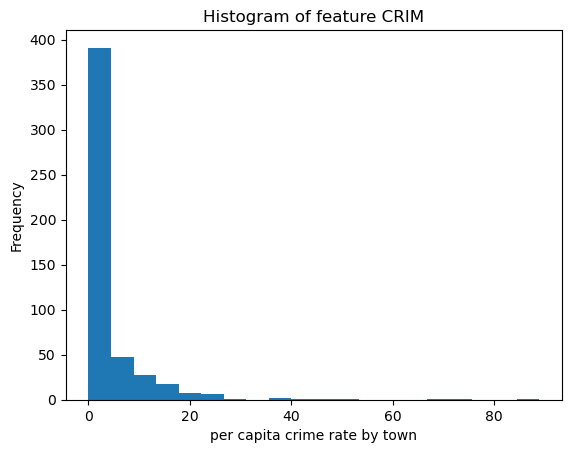

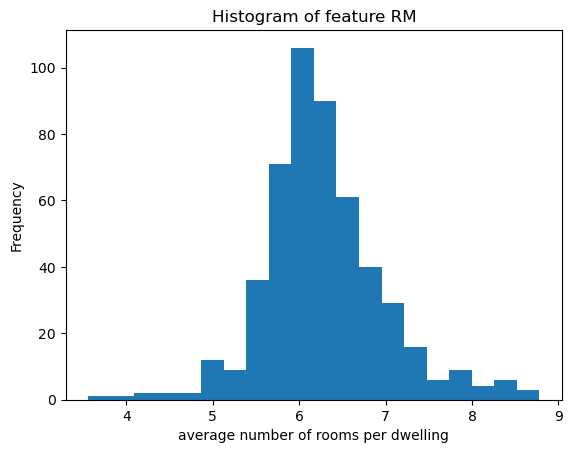

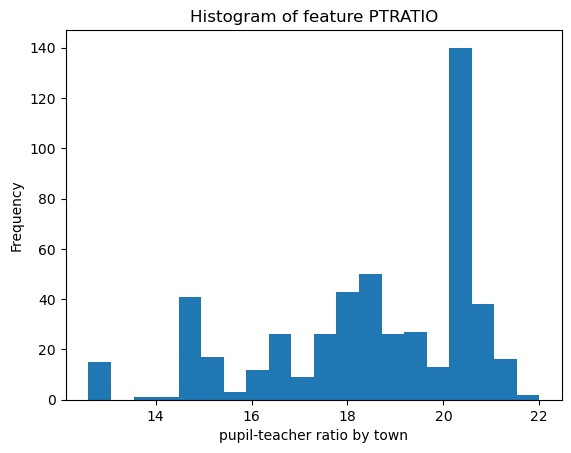

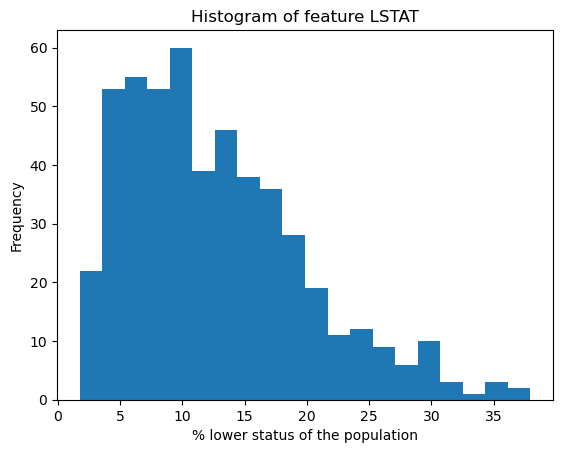

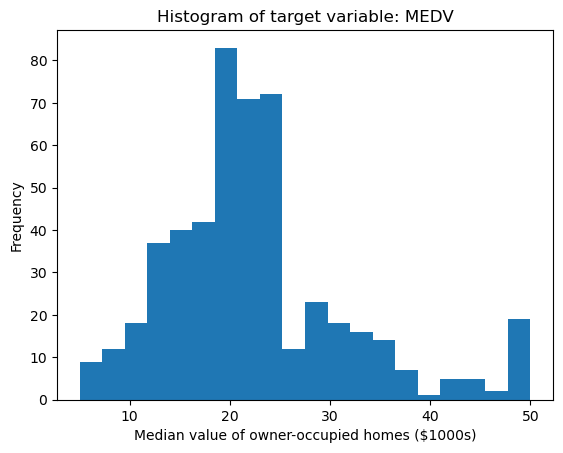

In [4]:
# Selecting specific features and plots (SOLUTION)
features = ['CRIM', 'RM', 'PTRATIO', 'LSTAT']
X = df[features]
y = df['MEDV']

# Define units for clarity
units = {
    'CRIM': 'per capita crime rate by town',
    'RM': 'average number of rooms per dwelling',
    'PTRATIO': 'pupil-teacher ratio by town',
    'LSTAT': '% lower status of the population',
    'MEDV': 'Median value of owner-occupied homes ($1000s)'
}



for f in features:
    plt.figure()
    plt.hist(df[f], bins = 20)
    plt.title(f'Histogram of feature {f}')
    plt.xlabel(units[f])
    plt.ylabel('Frequency')


plt.figure()
plt.hist(y, bins = 20)
plt.title(f"Histogram of target variable: MEDV")
plt.xlabel(units['MEDV'])
plt.ylabel('Frequency')


In [5]:
# Splitting the dataset into training and testing sets (TO BE DONE)
...


In [6]:
# Splitting the dataset into training and testing sets (SOLUTION)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features and output to have zero mean and unitary std

# Normalize training and test dataset. Note that training and test datasets are normalized using the same mean and std 
X_mean = X_train.mean(axis = 0)
X_std = X_train.std(axis = 0)
X_train = (X_train - X_mean)/X_std 
X_test = (X_test - X_mean)/X_std

y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean)/y_std 
y_test = (y_test - y_mean)/y_std

# sanity check:
print(f"Training features: \n Mean:\n {X_train.mean(axis = 0)} \n Std:\n {X_train.std(axis = 0)}\n")
print(f"Training target: \n Mean:\n {y_train.mean():.2f} \n Std:\n {y_train.std():.2f}")


Training features: 
 Mean:
 CRIM      -1.527931e-16
RM        -4.014391e-15
PTRATIO    2.001314e-14
LSTAT     -1.676327e-16
dtype: float64 
 Std:
 CRIM       1.0
RM         1.0
PTRATIO    1.0
LSTAT      1.0
dtype: float64

Training target: 
 Mean:
 0.00 
 Std:
 1.00


In [7]:
# Convert datasets to tensors (TO BE DONE)
...


In [ ]:
# Convert datasets to tensors (solution)

X_train_tensor = torch.tensor(X_train.values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

# Creat a linear model in Pytorch

In [9]:
# Define model (TBD)
...

tensor([[-8.6319e-02],
        [-1.8553e-01],
        [-7.0101e-01],
        [ 4.8342e-01],
        [-1.2442e-01],
        [-1.5683e-01],
        [-1.8580e-01],
        [-5.0382e-01],
        [ 5.4856e-01],
        [ 7.0739e-01],
        [-6.4187e-02],
        [-4.1219e-01],
        [ 5.2432e-02],
        [ 6.7477e-02],
        [ 5.7576e-01],
        [ 3.7618e-02],
        [-3.6920e-01],
        [-5.1813e-01],
        [-4.3740e-01],
        [-1.5601e-01],
        [-7.0415e-01],
        [-4.5473e-01],
        [-5.5456e-01],
        [-2.9381e-01],
        [-2.9589e-01],
        [ 3.9444e-02],
        [-6.6438e-01],
        [-9.8141e-03],
        [ 2.7546e-01],
        [-5.2399e-01],
        [ 1.7959e-01],
        [-8.5525e-02],
        [-6.5651e-01],
        [ 1.7062e-01],
        [-1.4729e-01],
        [-6.3757e-01],
        [-6.8190e-01],
        [ 2.4503e-01],
        [ 2.1088e-01],
        [-9.4865e-01],
        [-8.7060e-01],
        [-9.5552e-02],
        [-2.0199e-01],
        [-2

In [10]:
# Define model (solution)
model = nn.Linear(X.shape[1], 1) # define linear model with 4 features and 1 output variable
print(f"Model structure: {model}")

for name, params in model.named_parameters():
    print(f"parameter name: {name}. Value {params.data}")

# check what model provides:
y_hat = model(X_train_tensor)
y_hat.shape

Model structure: Linear(in_features=4, out_features=1, bias=True)
parameter name: weight. Value tensor([[-0.4244, -0.2506, -0.4627,  0.0949]])
parameter name: bias. Value tensor([0.2148])


torch.Size([404, 1])

In [12]:
# Define loss function

criterion = nn.MSELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


In [13]:
# training loop (TBD)

max_iter = 1000
for it in range(max_iter):

    ...
    

    



In [14]:
# training loop (SOLUTION)
max_epochs = 1000
for it in range(max_epochs):
    optimizer.zero_grad()
    y_hat = model(X_train_tensor)
    loss = criterion(y_hat, y_train_tensor.view(-1,1))
    loss.backward()
    optimizer.step()
    if it % 5 == 0:
        print(f"Iteration: {it}. Loss: {loss.item() :3f}")
    


Iteration: 0. Loss: 1.183661
Iteration: 5. Loss: 0.997315
Iteration: 10. Loss: 0.858267
Iteration: 15. Loss: 0.752620
Iteration: 20. Loss: 0.670954
Iteration: 25. Loss: 0.606813
Iteration: 30. Loss: 0.555714
Iteration: 35. Loss: 0.514499
Iteration: 40. Loss: 0.480904
Iteration: 45. Loss: 0.453279
Iteration: 50. Loss: 0.430400
Iteration: 55. Loss: 0.411341
Iteration: 60. Loss: 0.395391
Iteration: 65. Loss: 0.381992
Iteration: 70. Loss: 0.370704
Iteration: 75. Loss: 0.361172
Iteration: 80. Loss: 0.353108
Iteration: 85. Loss: 0.346275
Iteration: 90. Loss: 0.340480
Iteration: 95. Loss: 0.335560
Iteration: 100. Loss: 0.331379
Iteration: 105. Loss: 0.327824
Iteration: 110. Loss: 0.324800
Iteration: 115. Loss: 0.322227
Iteration: 120. Loss: 0.320035
Iteration: 125. Loss: 0.318169
Iteration: 130. Loss: 0.316579
Iteration: 135. Loss: 0.315224
Iteration: 140. Loss: 0.314069
Iteration: 145. Loss: 0.313084
Iteration: 150. Loss: 0.312243
Iteration: 155. Loss: 0.311526
Iteration: 160. Loss: 0.310915

In [ ]:
# For linear models, model interpration is possible and easy. Let us look at the values of the parameters

In [15]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.0830,  0.3850, -0.1923, -0.3969]], requires_grad=True)
Parameter containing:
tensor([-3.6371e-09], requires_grad=True)


torch.Size([102, 1]) torch.Size([102])
tensor(1.4967) tensor(0.6226)


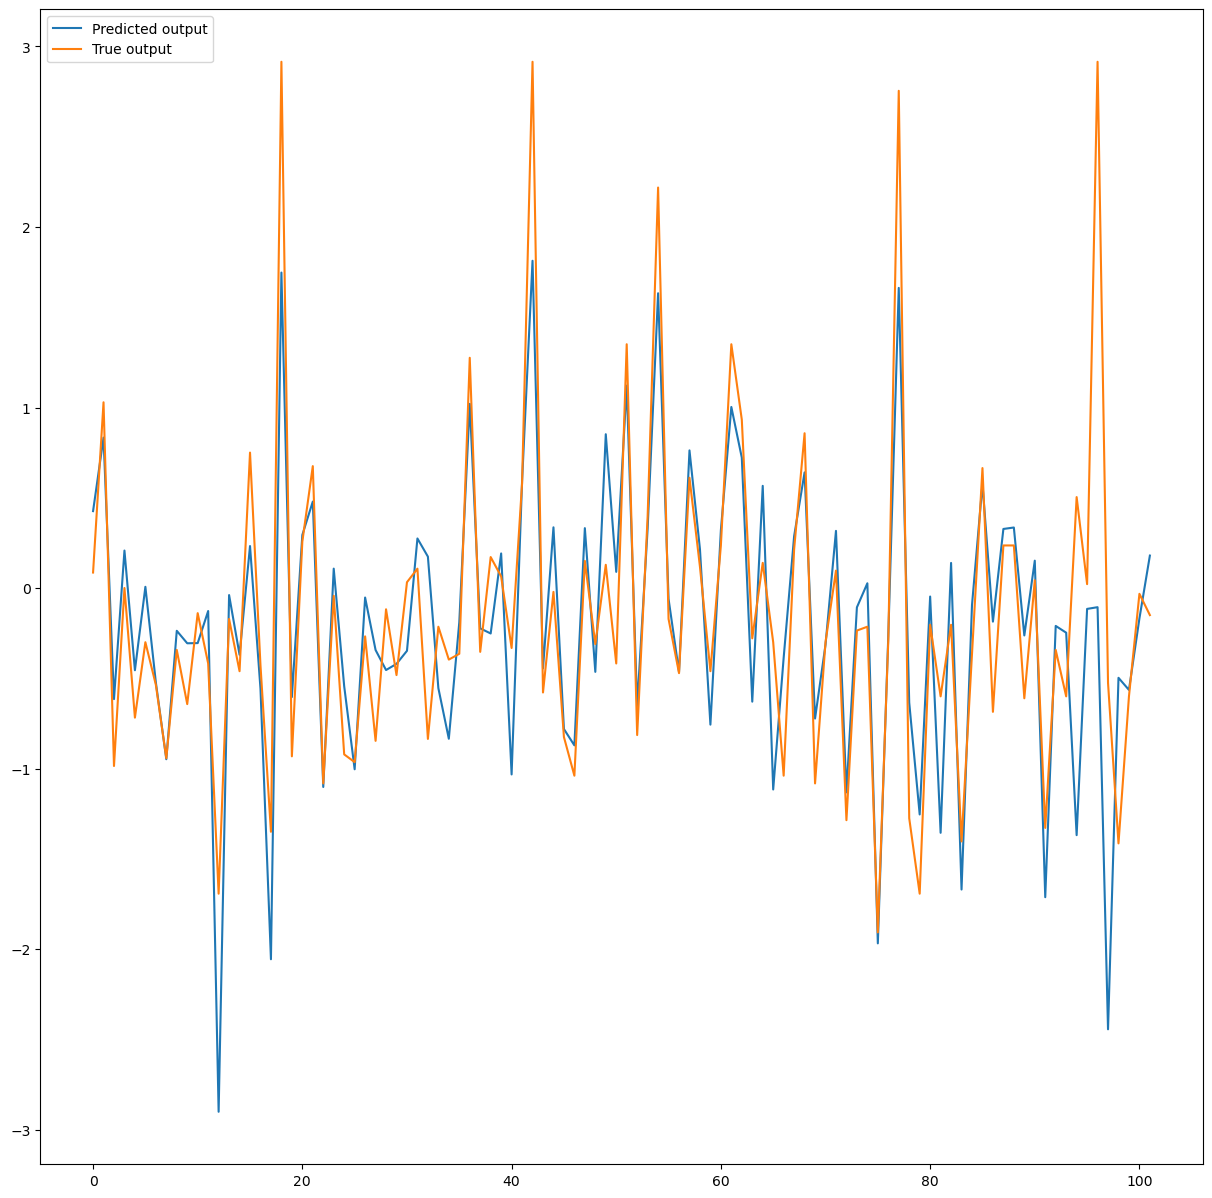

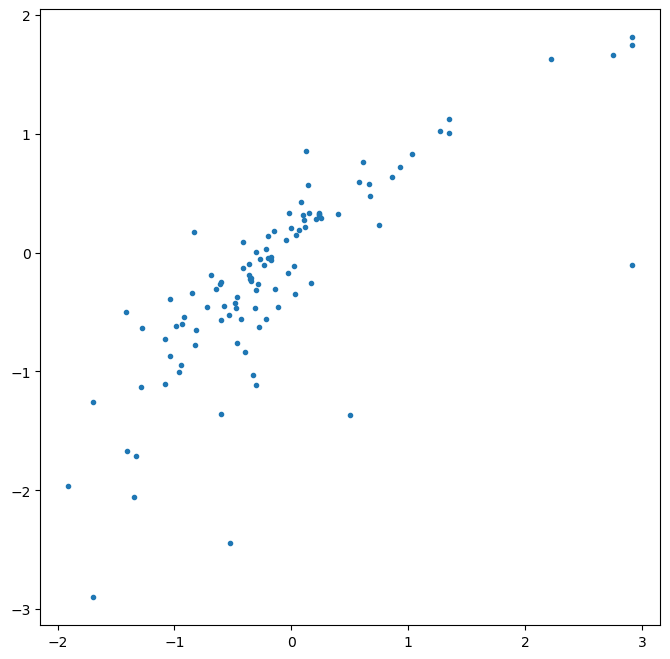

In [16]:
# Assess final results (TBD)



In [17]:
# Assess final results (solution)

def assess_results(model, X, y, data_type):
    with torch.no_grad():
        y_hat = model(X)
        
        # Prediction and plotting
        plt.figure(figsize = (12, 12))
        plt.plot(y_hat.numpy(), 'r-', label='Predicted output')
        plt.plot(y.numpy(), 'b-', label='True output')
        plt.title(f'Predicted vs Estimated output: {data_type} dataset')  # Fixed f-string
        plt.legend()
        plt.show()

        # Prediction and plotting
        plt.figure(figsize = (5, 5))
        plt.scatter(y_hat.numpy(), y.numpy())
        plt.xlabel('Predicted output')
        plt.ylabel('True output')
        plt.title(f'Predicted vs Estimated output: {data_type} dataset')  # Fixed f-string
        plt.legend()
        plt.show()
        
        # RMSE calculation
        mse = torch.mean((y_hat - y) ** 2)
        rmse = torch.sqrt(mse)
        

        # R2 calculation
        total_variance = torch.var(y)
        residual_variance = torch.mean((y_hat - y) ** 2)
        R2 = 1 - residual_variance / total_variance

    return rmse, R2 
    


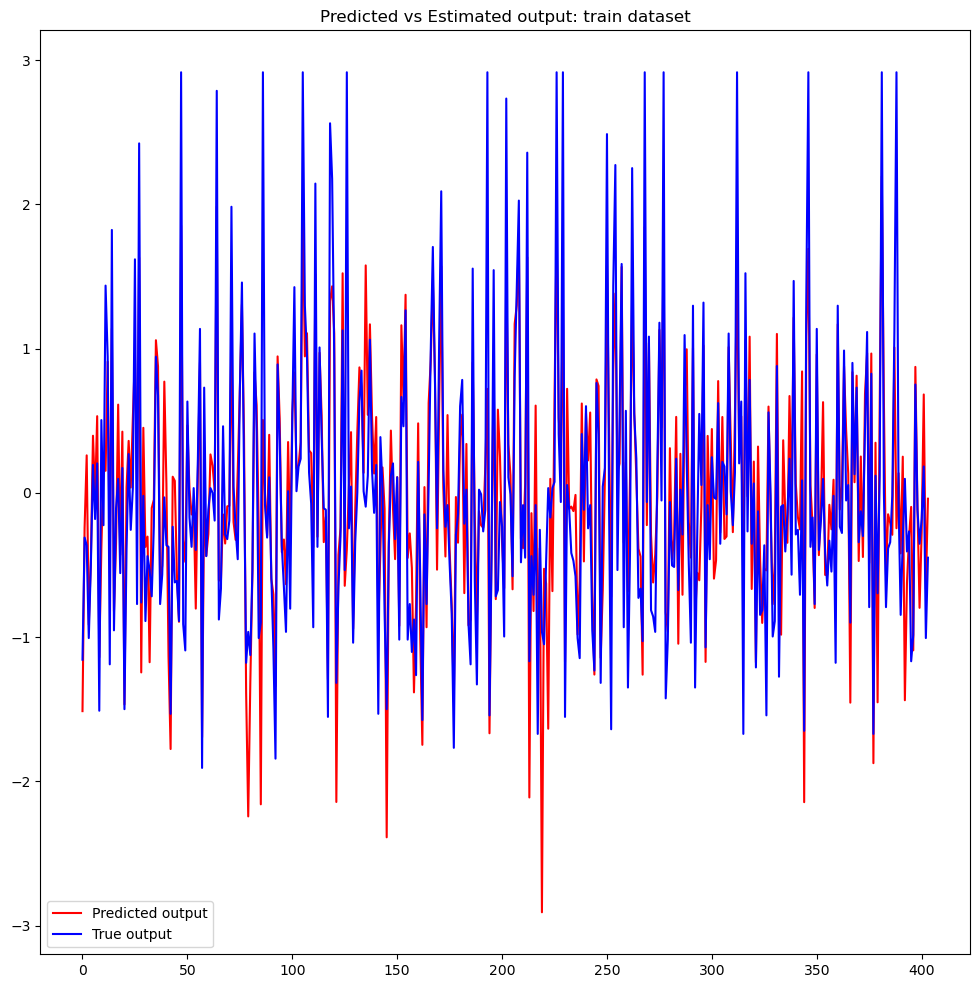

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


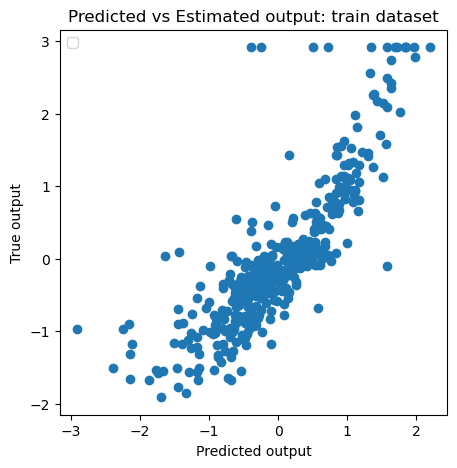

Training results
rmse = 0.5543351173400879. R2 = 0.693


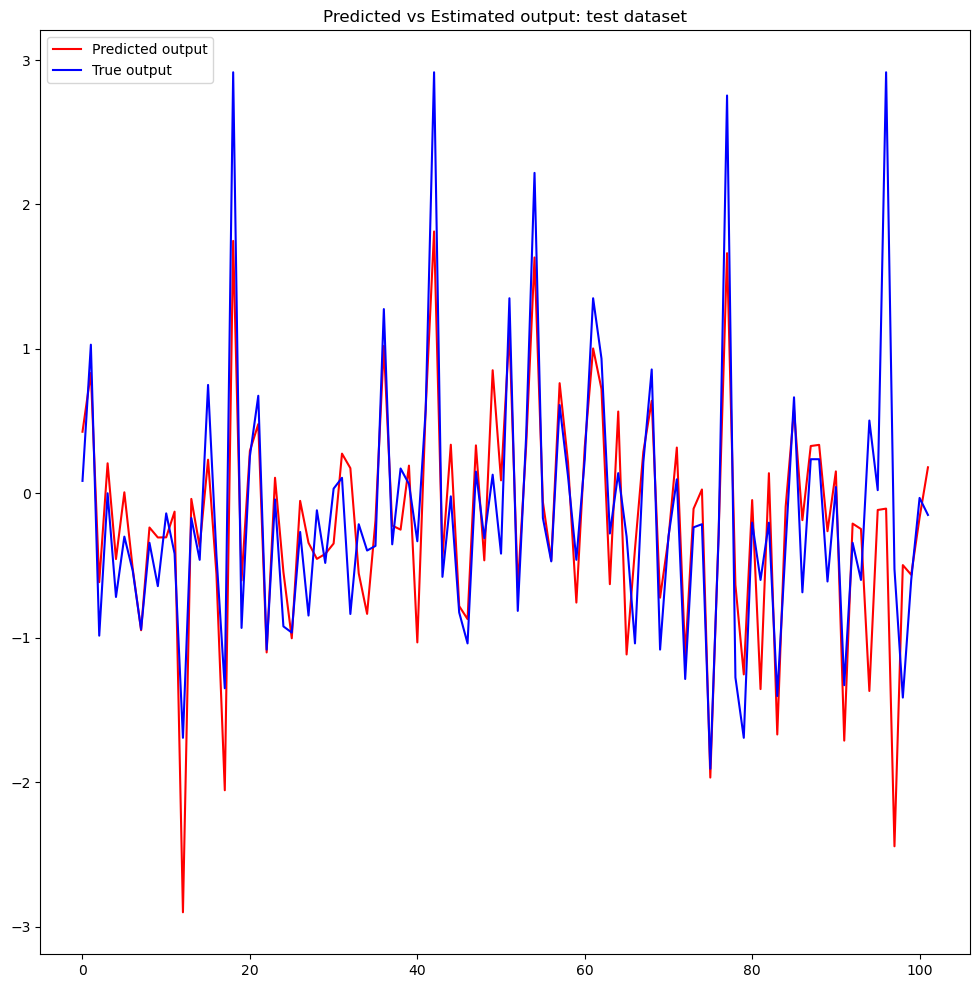

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


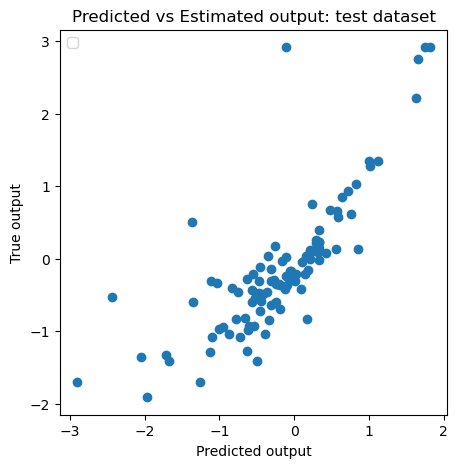

Training results
rmse = 0.5665038824081421. R2 = 0.623


In [18]:
# Assess results in training
rmse, R2 = assess_results(model, X_train_tensor, y_train_tensor.view(-1,1), data_type = 'train')
print('Training results')
print(f"rmse = {rmse}. R2 = {R2:.3f}")


# Assess results in test
rmse, R2 = assess_results(model, X_test_tensor, y_test_tensor.view(-1,1), data_type = 'test')
print('Training results')
print(f"rmse = {rmse}. R2 = {R2:.3f}")